In [2]:
%matplotlib inline
from K.utils.utils import *
import pandas as pd

# Table of Contents
### 1. Input Data

### 2. CNN 모델링
  * Filter Size
  * Kernel 초기화
  * Batch Normalization
  * Activation Function
  
### 3. Optimizer

### 4. Training
  * Cost Function
  * Mini Batch Training
  * Callbacks
  * Batch Generator & Real-time Data Augmentation
  * 정규화
  
### 5. Optimization
  * 1등 vs. 앙상블
  * OpenCV
  * Advanced Data Augmentation
  
### 6. Final Kaggle Submission

# 1. Input Data
  * 15 Facial Keypoints to Detect
  * Two Diffrent Dataset
    * 4 Keypoints
    * 11 Keypoints
   

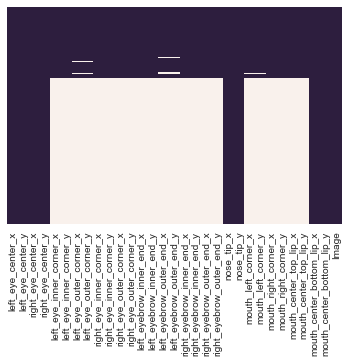

In [2]:
df = pd.read_csv('./data/training.csv')
sns.heatmap(df.isnull() == False, cbar=False, yticklabels=False)

# 2. CNN  모델링

<table>
    <tr>
        <td><img src="img/cnn_model.png" width=300 /></td>
        <td><img src="img/summary.png" width=500/></td>
    </tr>
</table>
<img src="img/cnn model cogimo.jpg" width=700/>


* ### Filter Size
  * 3 vs 5

* ### Kernel 초기화
  * He Normal
    * $ \text{Truncated Normal}(0, \sqrt{\text{# of input units}}) $

* ### Batch Normalization
  * Gradient Vanishing 현상을 막아주는 방법
  * Learning rate를 높게 주어도 학습을 잘하기 때문에 수렴속도가 빠름
  * 학습을 할 때 마다 출력값을 정규화로 만들어 주기 때문에, 초기화 전략에 영향을 덜 받음

* ### Activation Function
  * Rectified Linear Units (ReLU)
  * Hyperbolic Tangent

# 3. Optimizer (학습방법)

* Stochastic Gradient Descent
$$
\theta \leftarrow \theta - \eta \nabla_{\theta}J(\theta)
$$

* Adagrad
$$
G_t \leftarrow G_{t-1} + (\nabla_{\theta}J(\theta_t))^2
$$

$$
\theta_{t+1} \leftarrow \theta_t - \frac{\eta}{\sqrt{G_t+\epsilon}}\cdot \nabla_{\theta}J(\theta_t)
$$

* <strong>RMSProp</strong>
$$
G_t \leftarrow \gamma{G_{t-1}} + (1-\gamma)(\nabla_{\theta}J(\theta_t))^2
$$

$$
\theta_{t+1} \leftarrow \theta_t - \frac{\eta}{\sqrt{G_t+\epsilon}}\cdot \nabla_{\theta}J(\theta_t)
$$

```python
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-8, decay=0)
```

<img src="img/opts.gif" width=500/>
Ref: http://i.imgur.com/2dKCQHh.gif?1

# 4. Training

### Cost Function
  * Mean Squared Error
  * Root Mean Squared Error
  
```python
import keras.backend as K
def rmse(target, y_predicted):
    rmse = K.sqrt(K.mean(K.square(y_predicted - target))) * 48
    return rmse
```

### Mini-Batch Training
  * Dataset 1
    * N = 7000
    * Batch Size = 256
  * Dataset 2
    * N = 2155
    * Batch Size = 128

### Callbacks
  * ModelCheckpoint
    * 매 Epoch마다 트레인 된 weight 값들을 저장
  * EarlyStopping
    * MSE를 모니터링
    * 마지막 50 Epochs동안 퍼포먼스 향상이 없다면 스탑

### Batch Generator & Real-time Data Augmentation
  * 매 배치마다 이미지 데이터를 새롭게 증강 시킨다.
  * 장단점
    * 무한한 방법으로 변환 가능한 이미지 데이터
    * 매배치다가 이미지들를 변환 시켜서 트레이닝이 느려짐

In [3]:
X_train, _, Y_train, _ = load_train_data_and_split("data/training.csv", COLS, 0.1)

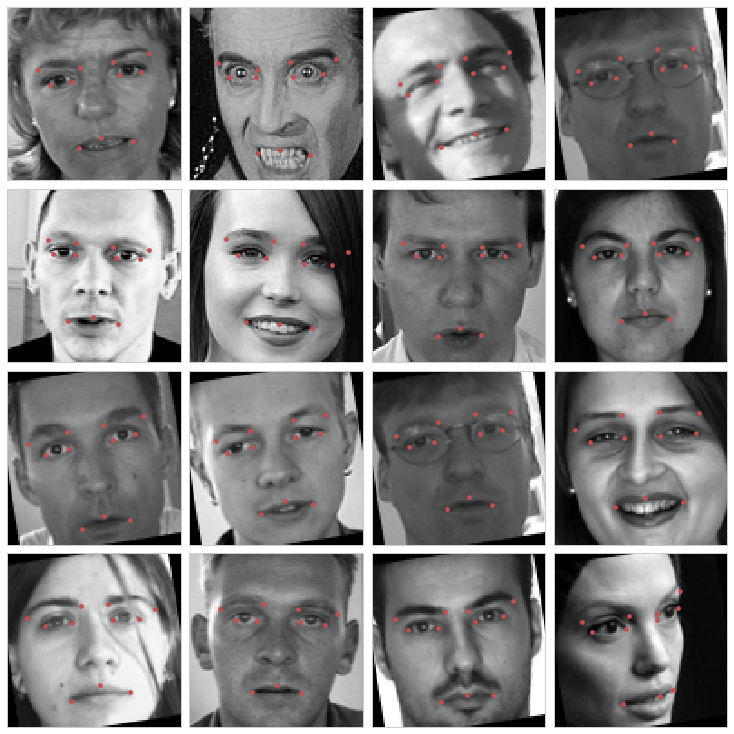

In [17]:
generate_augmented_images(X_train, Y_train, True, True, True, False, False)

### Regularization
  * L1 & L2
  * Dropout
  * <strong>No Regularizations!</strong>

# 5. Optimization

## One Best Model vs. Ensemble
* 모든 모델이 주어진 테스트 데이터에 대해 똑같은 에러를 만들지 않는다.
* Model averaging을 통해 Generalization Error를 줄여보자.

### Ensemble

In [5]:
model_name = 'model_20171117_1723'
X_test = load_test_data('./data/test.csv')

In [6]:
model = load_models_with_weights(model_name)
_ = predict_and_make_submission_file(X_test, model)

submission_20171122_1238.csv created for submission.


* Score (RMSE) of submission_20171120_0110.csv
  * public:  <strong>2.57497</strong>
  * private: <strong>2.52040</strong>

### Best CNN Model

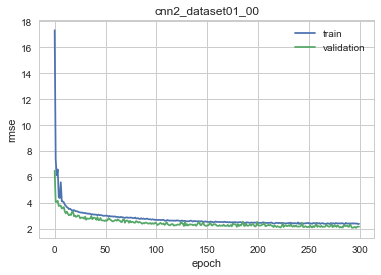

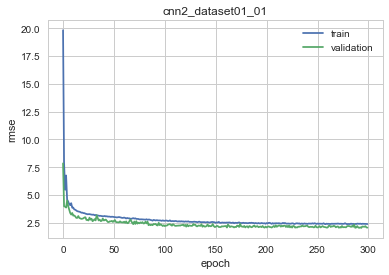

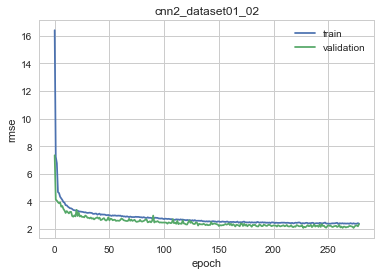

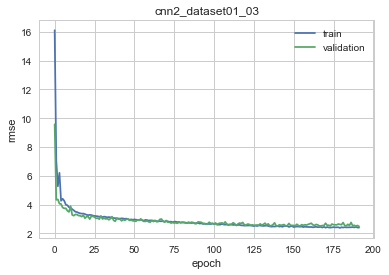

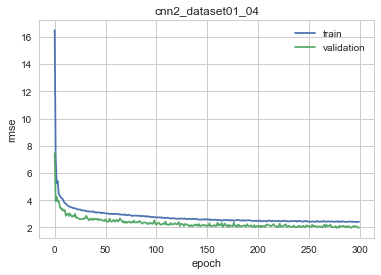

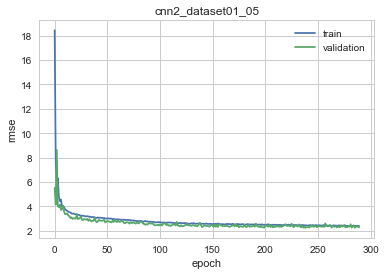

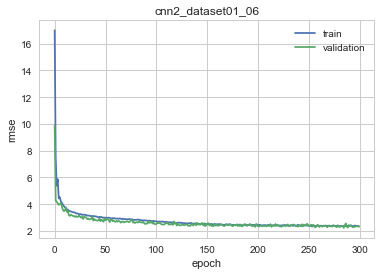

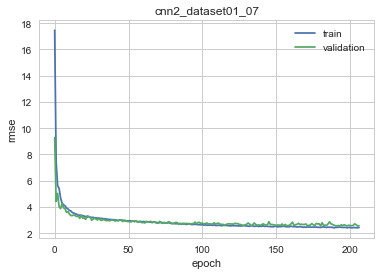

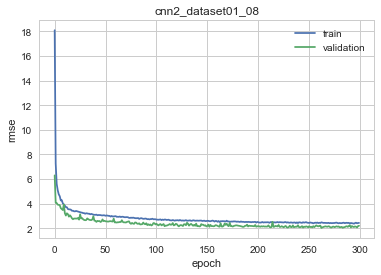

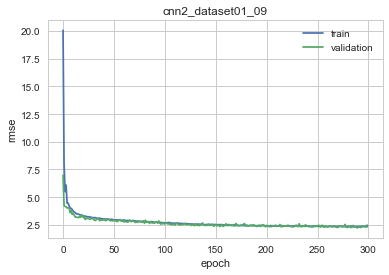

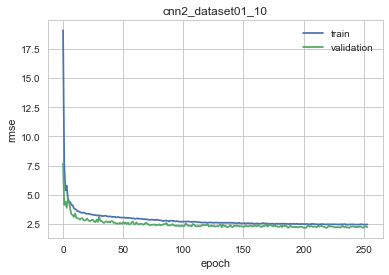

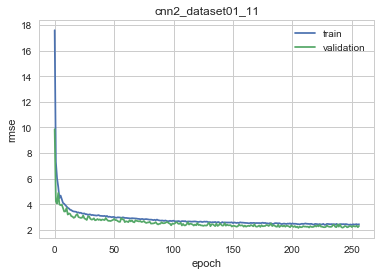

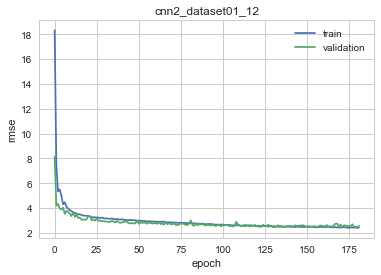

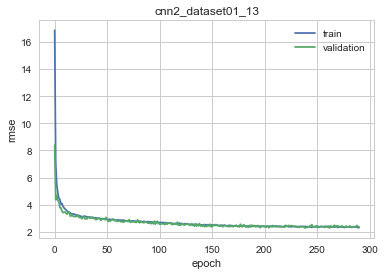

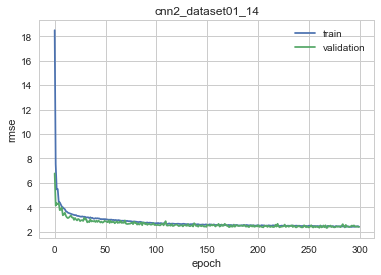

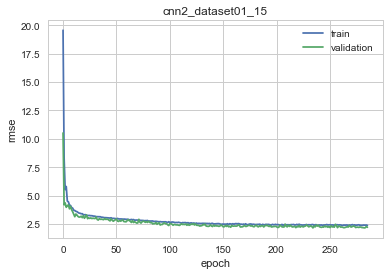

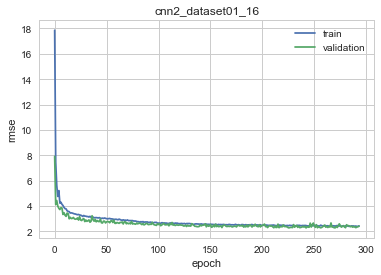

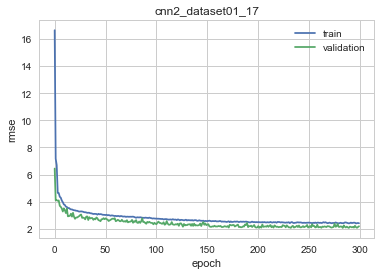

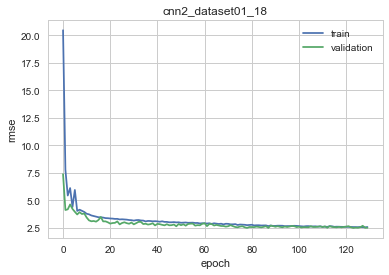

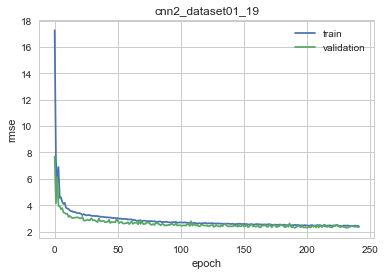

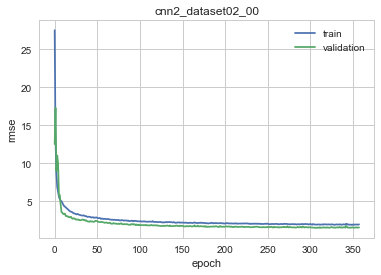

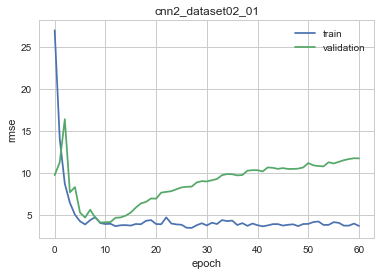

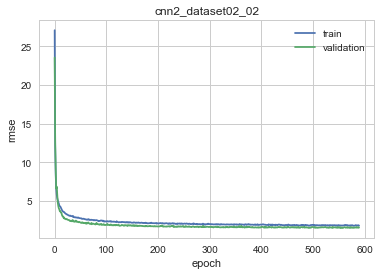

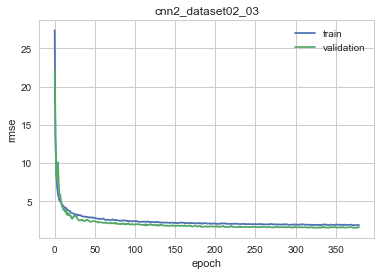

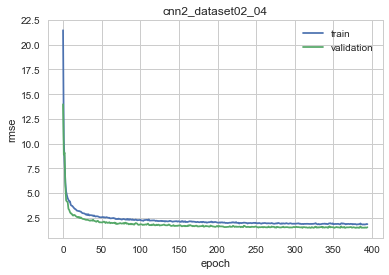

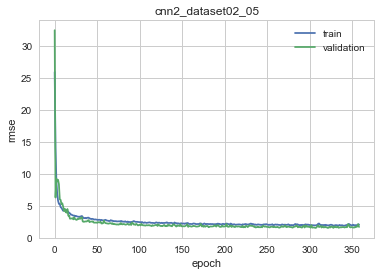

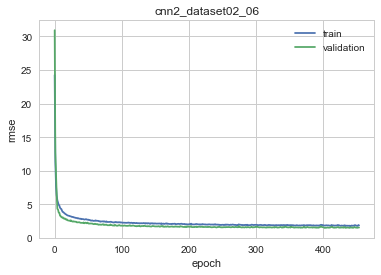

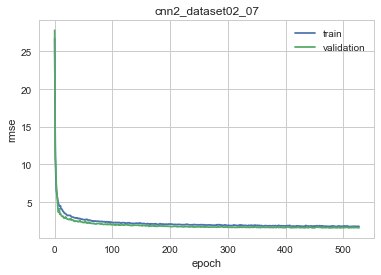

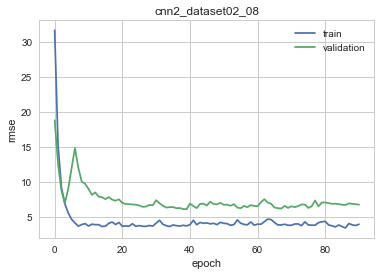

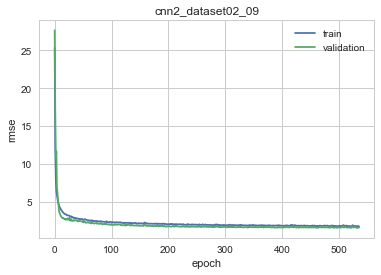

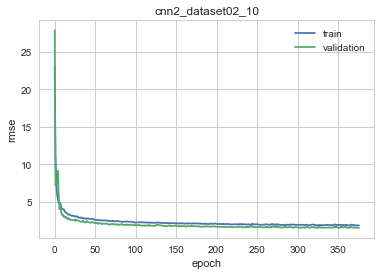

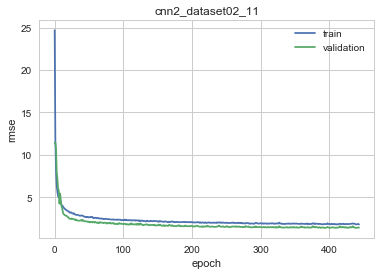

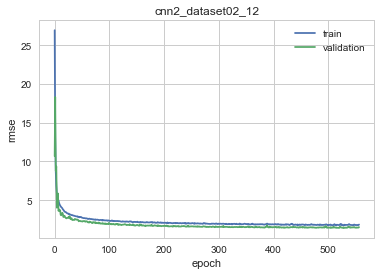

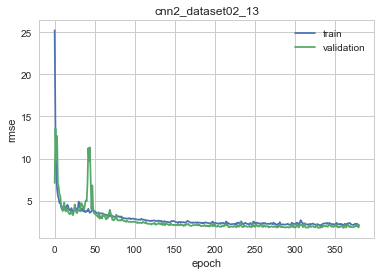

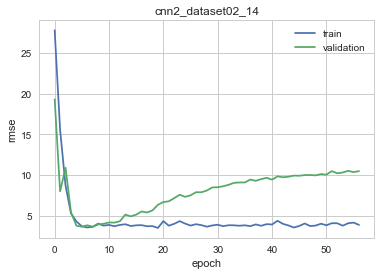

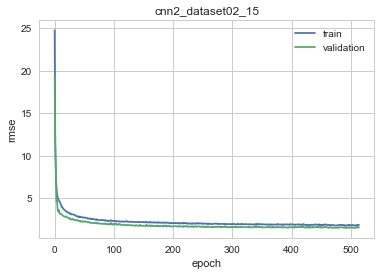

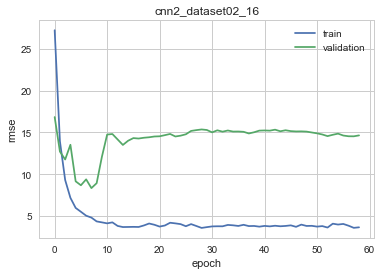

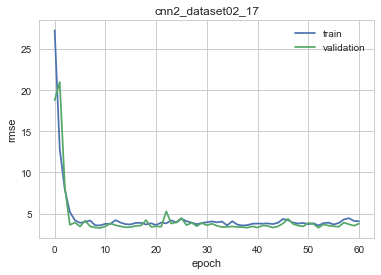

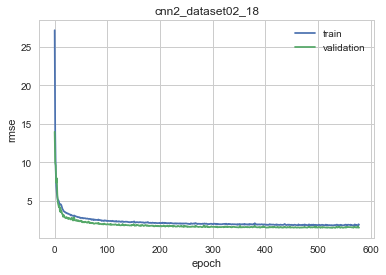

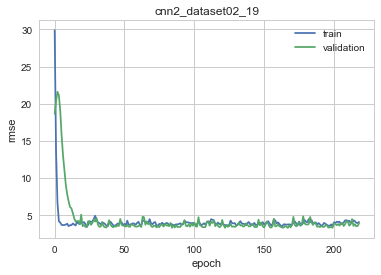

In [7]:
plot_loss_history(model_name, 'cnn2_dataset01', 20)
plot_loss_history(model_name, 'cnn2_dataset02', 20)

In [8]:
best_cnns = pick_cnns(model, [4], [25])
_ = predict_and_make_submission_file(X_test, best_cnns)

submission_20171122_1238.csv created for submission.


* Score (RMSE) of submission_20171120_0116.csv
  * public:  <strong>2.25358</strong>
  * private: <strong>2.02075</strong>

### Selected Ensemble

In [9]:
indexes08 = [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19] 
indexes22 = [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 15, 18, 21, 22, 25, 27, 29]
selected_ensemble = pick_cnns(model, indexes08, indexes22)
_ = predict_and_make_submission_file(X_test, selected_ensemble)

submission_20171122_1242.csv created for submission.


* Score (RMSE) of submission_20171120_0132.csv
  * public:  <strong>2.14311</strong>
  * private: <strong>1.92491</strong>

베스트모델 하나보다 성능 좋은 여러개의 모델들의 앙상블모델이 더 좋은 성능을 보여준다.

## OpenCV
  * OpenCV2로 얼굴을 인식하여 Face Bounding Box를 찾고 그 안에서 예측해보자.

1137


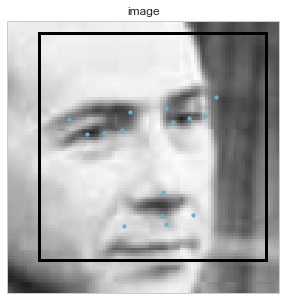

In [10]:
import random

def plot_keypoints_with_cv2(x, model):
    face_classifier = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')

    img = to_img(x.reshape(-1)*255)

    cv2_img = np.array(img)[:, :, ::-1].copy()
    cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(cv2_img, 1.01, 9)
    image_with_detections = np.copy(cv2_img)
        
    fig = plt.figure(figsize = (5,5))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('image')
    
    for (box_x,box_y,box_w,box_h) in faces:
        detected_face = cv2_img[box_y:box_y+box_h,box_x:box_x+box_w]
        scale = box_w/96
        reshaped = np.reshape(cv2.resize(detected_face, (96, 96)), (1, 96, 96, 1)) # Reshape image
        normalized = reshaped / 255 
        cv2.rectangle(image_with_detections, (box_x,box_y), (box_x+box_w,box_y+box_h), (0,0,255), 1)

    landmarks = predict_with_cv2(np.array([x]), model)
    ax1.scatter(landmarks[0, 0::2], landmarks[0, 1::2], marker='o', c='c', s=15)
    ax1.imshow(image_with_detections, cmap='gray')

# idx = random.randint(0, len(X_test)-1)
idx=1137
print(idx)
plot_keypoints_with_cv2(X_test[idx], selected_ensemble)

In [11]:
_ = predict_with_cv2_and_make_submission_file(X_test, selected_ensemble)

submission_20171122_1248.csv created for submission.


* score (RMSE): submission_20171120_1719.csv
  * public:  <strong>2.83592</strong>
  * private: <strong>2.51648</strong>
* False Positive가 잦은 이유 때문

## Advanced Augmentation
  * Elastic Transformation
  * Perspective Transformation

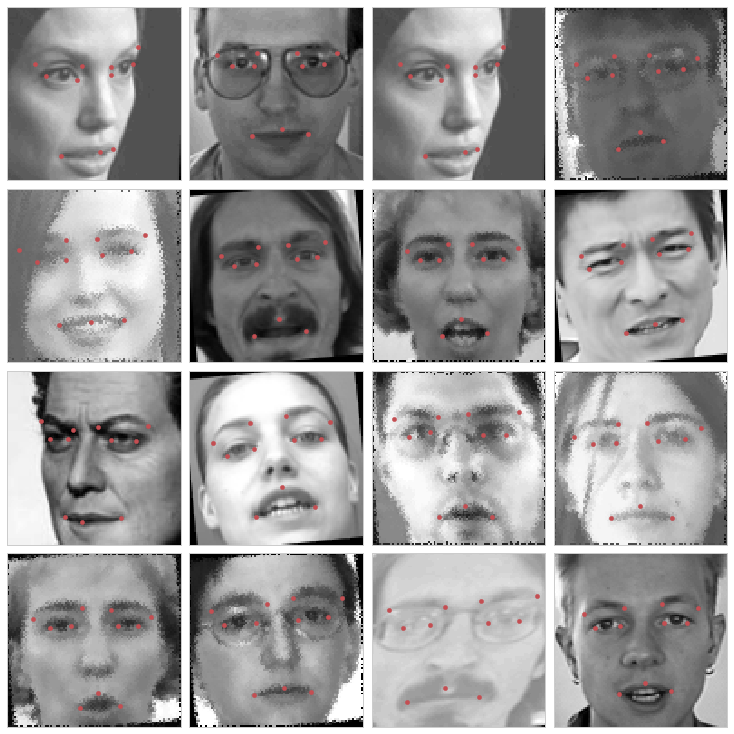

In [12]:
generate_augmented_images(X_train, Y_train, True, True, True, True, True)

In [13]:
final_model_name = 'final_model'
final_model = load_models_with_weights(final_model_name)

In [14]:
len(final_model[0]), len(final_model[1])

(61, 53)

성능 좋은 CNN 모델들을 선택해서 앙상블 모델을 구성해보자.

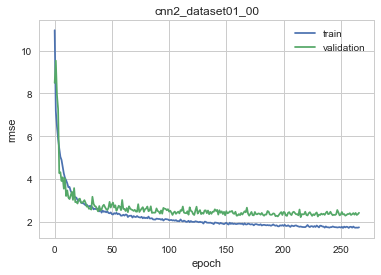

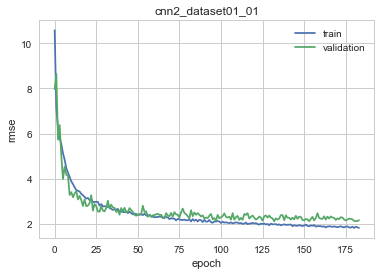

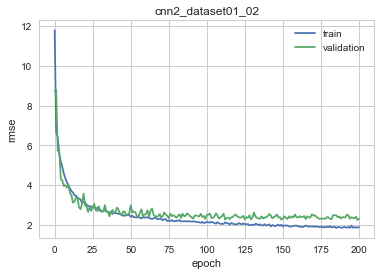

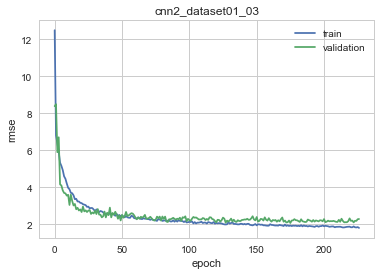

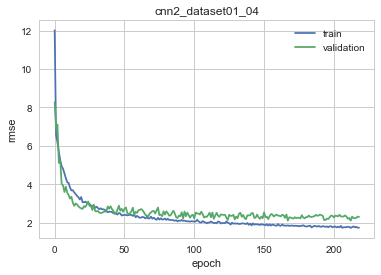

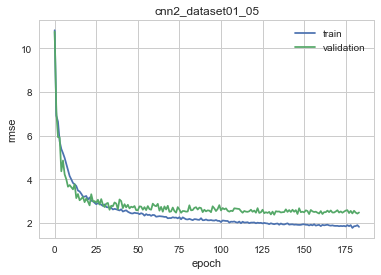

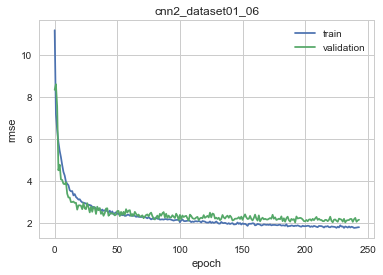

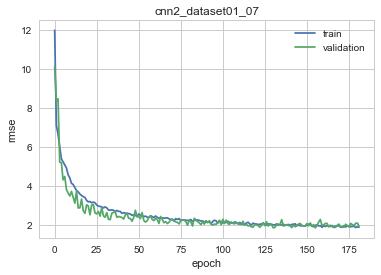

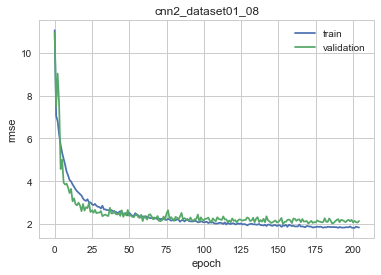

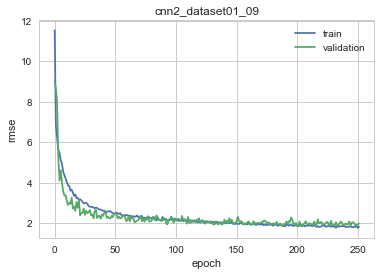

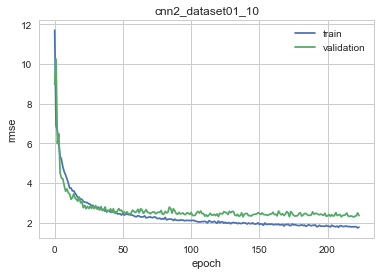

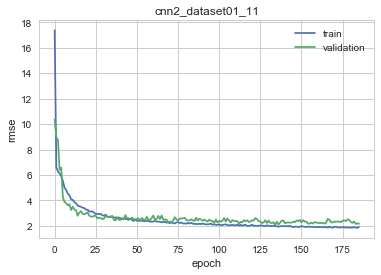

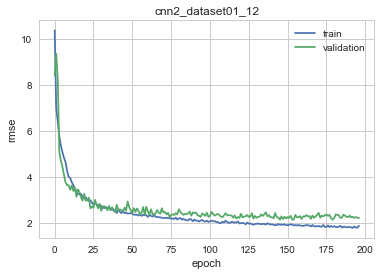

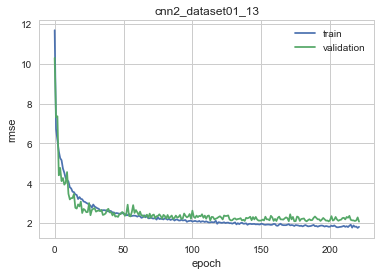

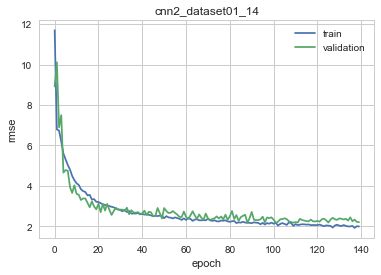

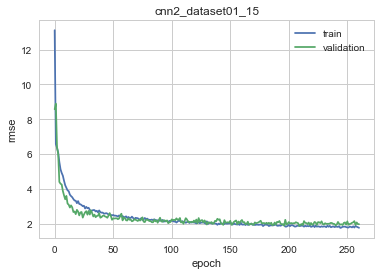

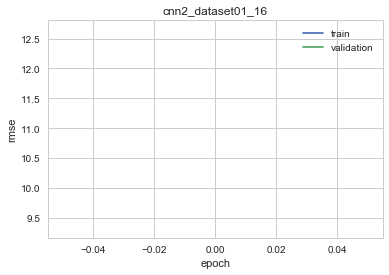

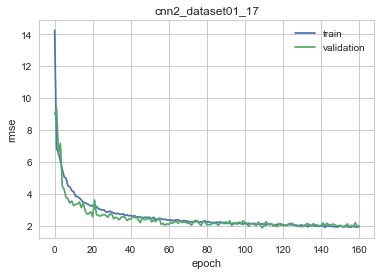

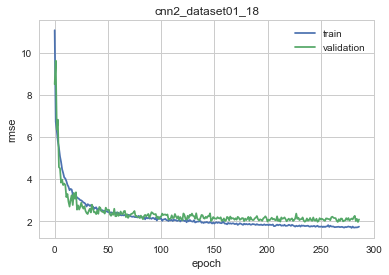

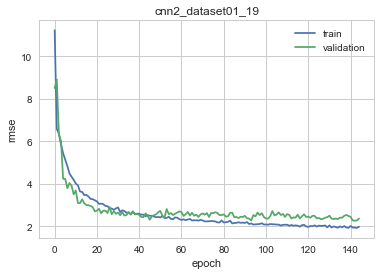

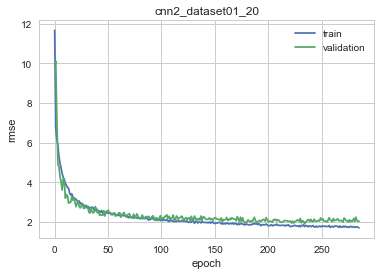

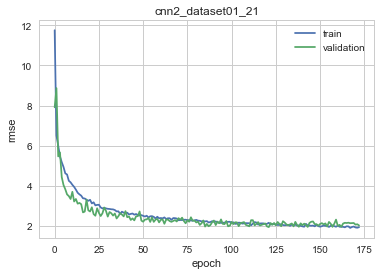

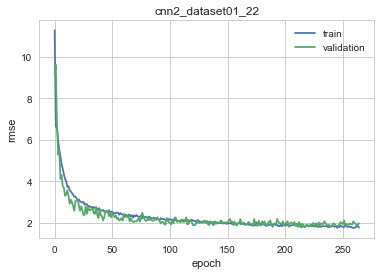

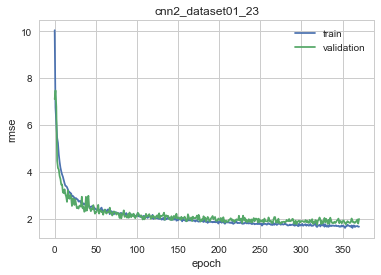

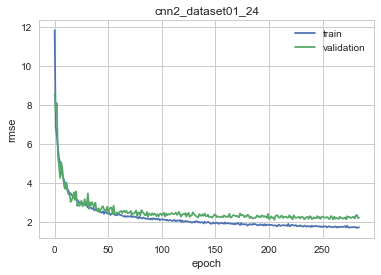

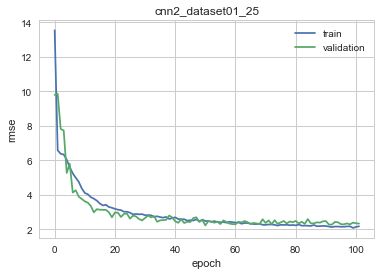

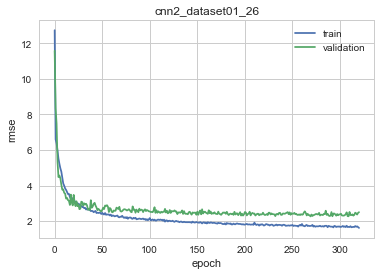

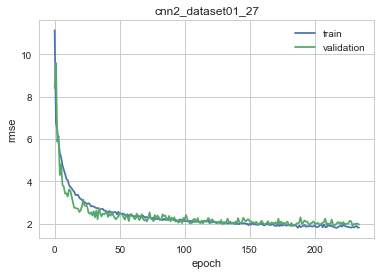

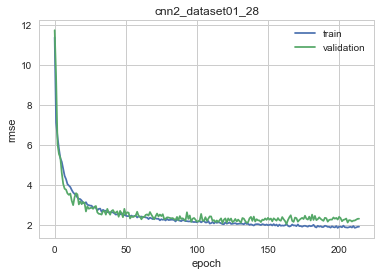

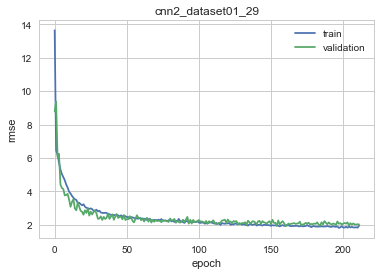

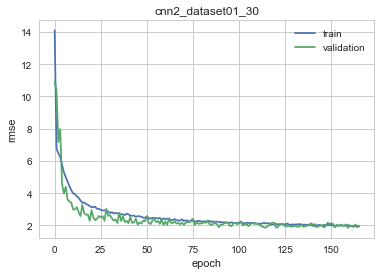

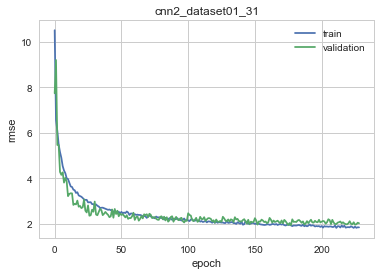

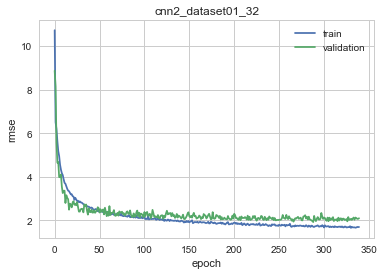

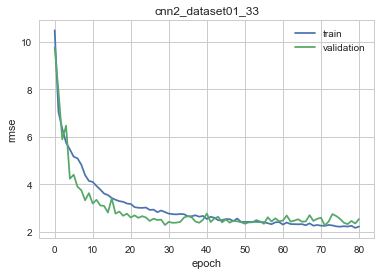

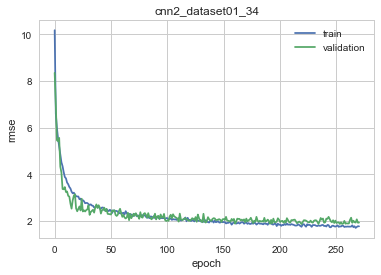

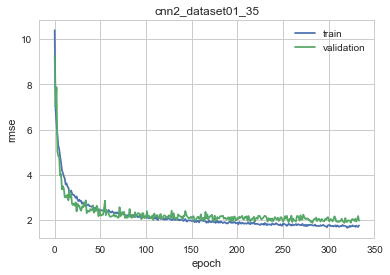

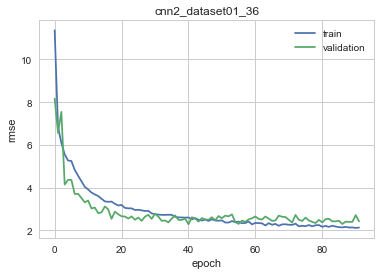

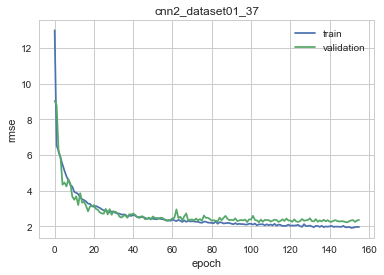

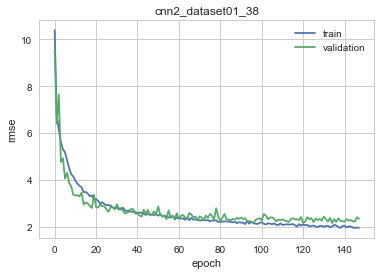

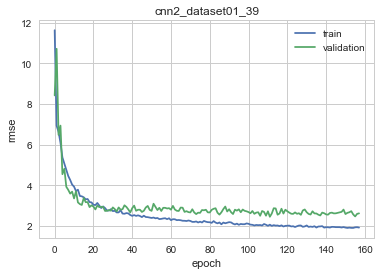

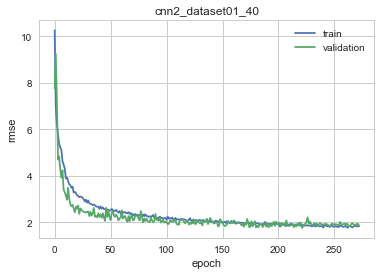

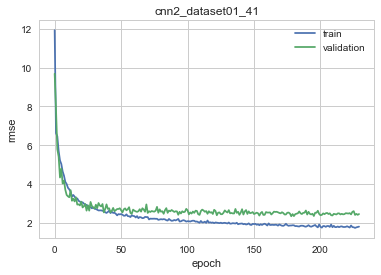

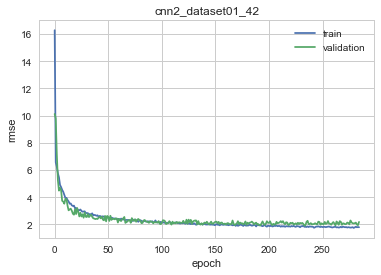

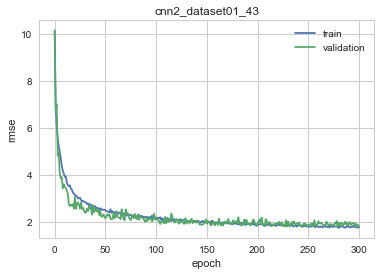

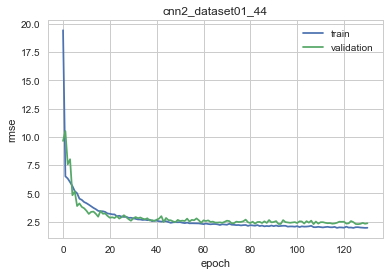

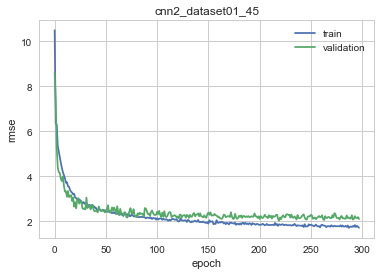

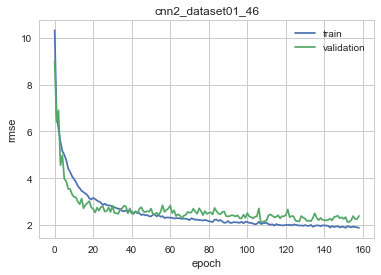

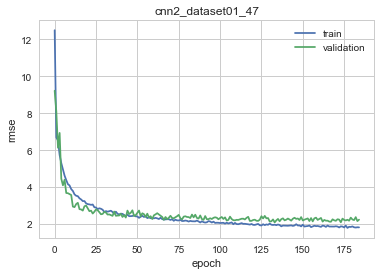

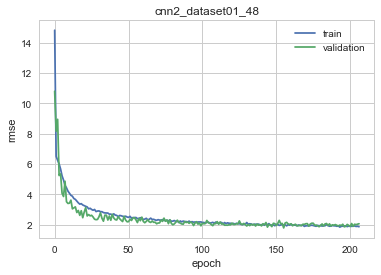

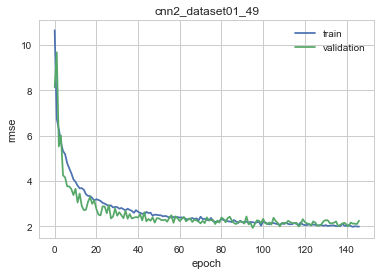

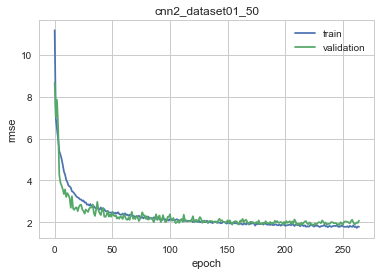

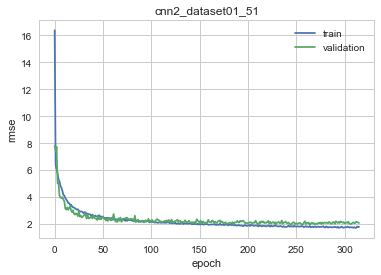

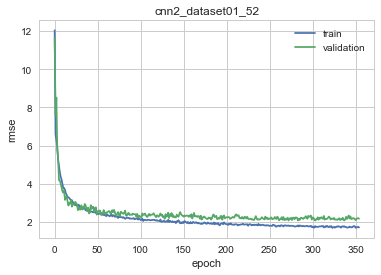

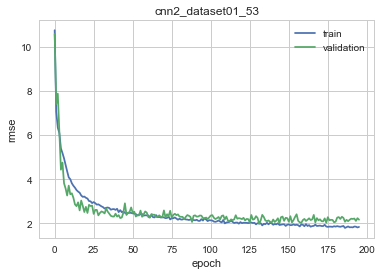

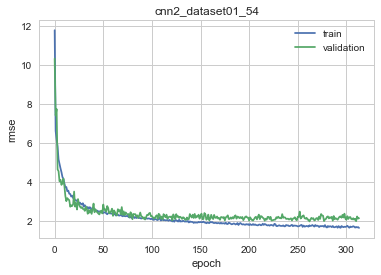

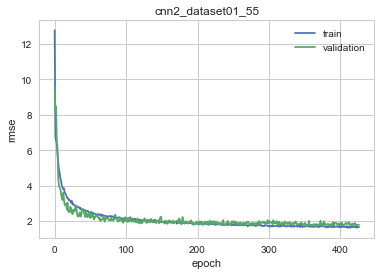

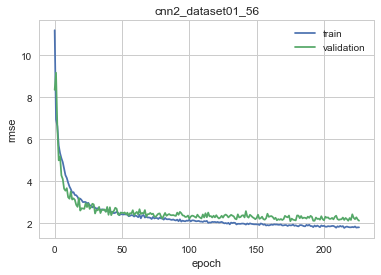

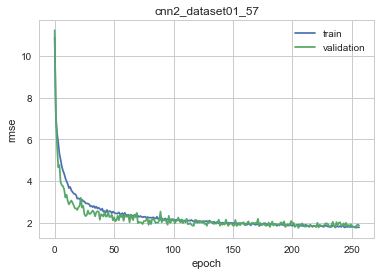

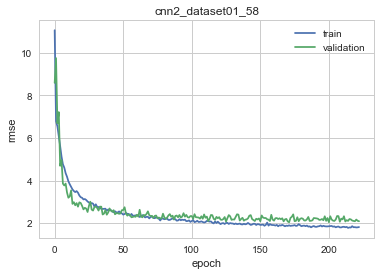

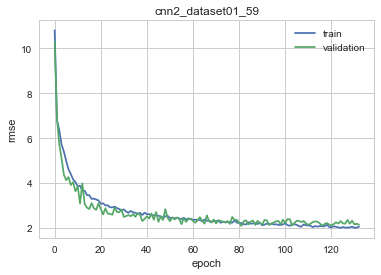

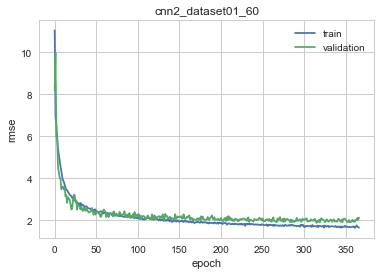

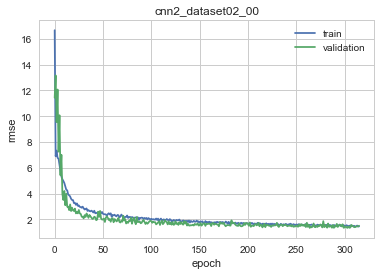

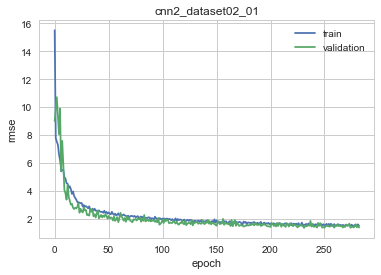

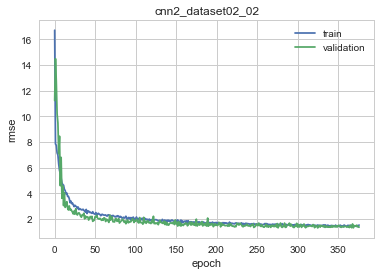

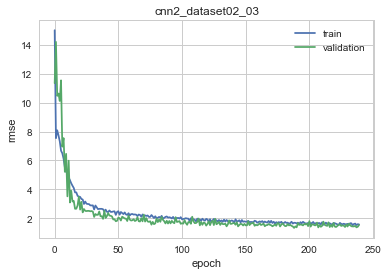

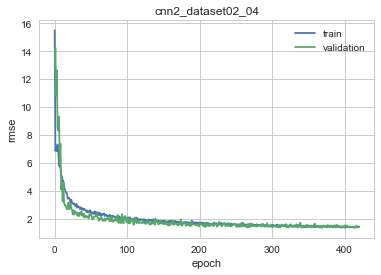

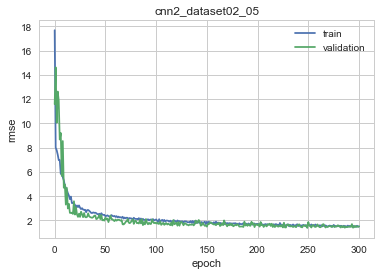

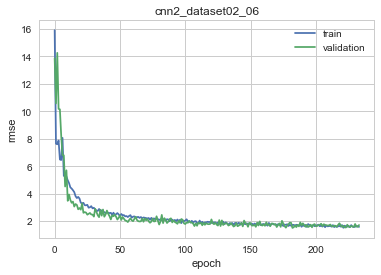

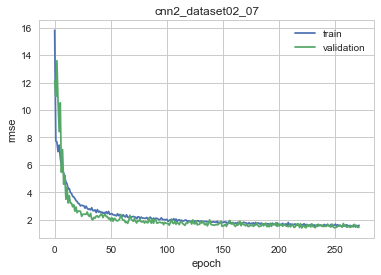

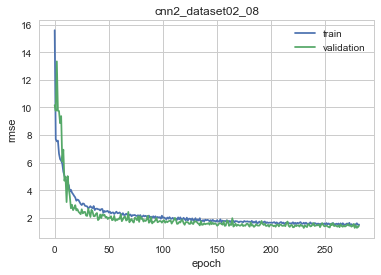

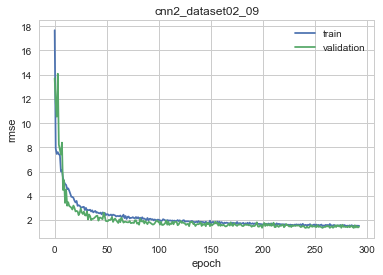

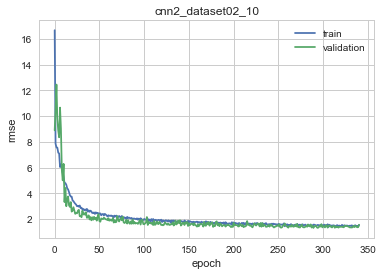

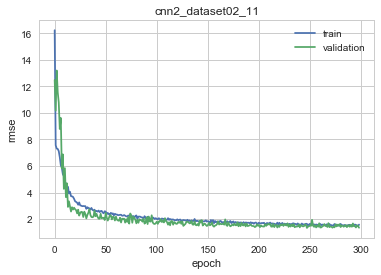

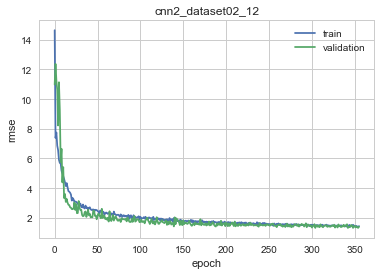

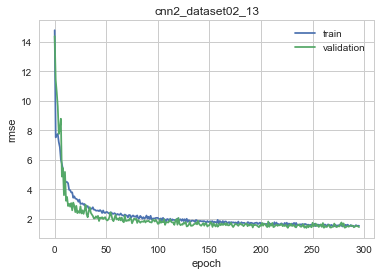

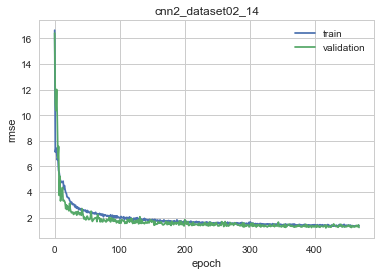

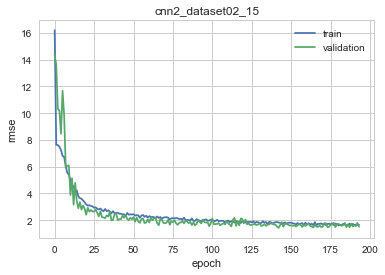

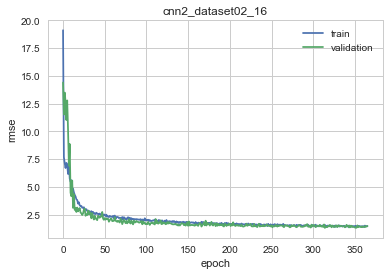

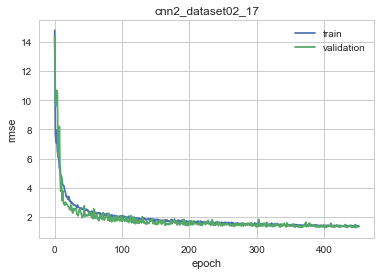

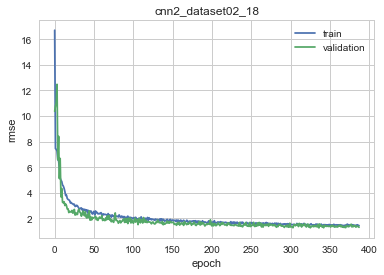

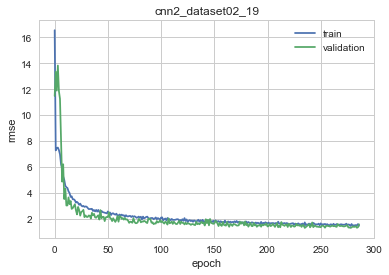

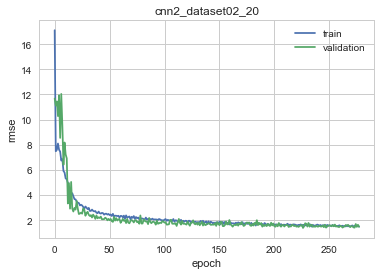

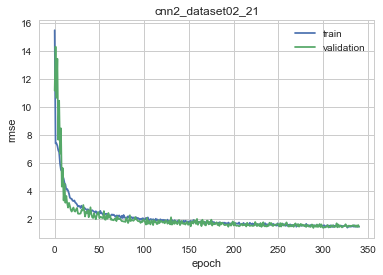

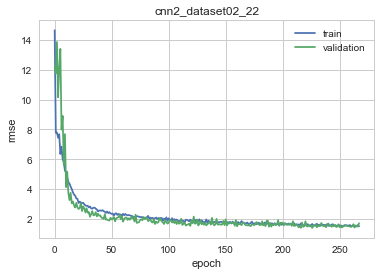

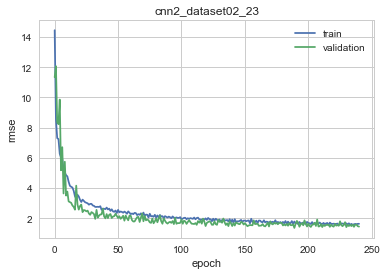

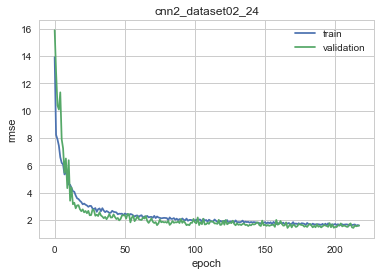

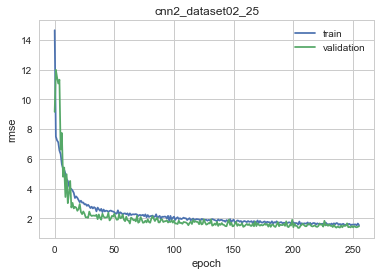

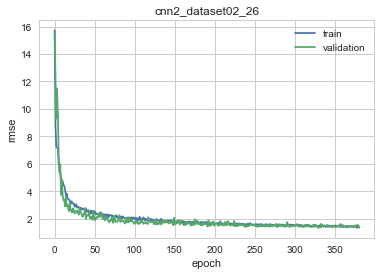

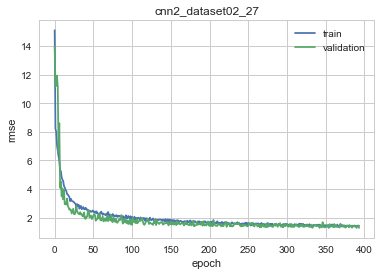

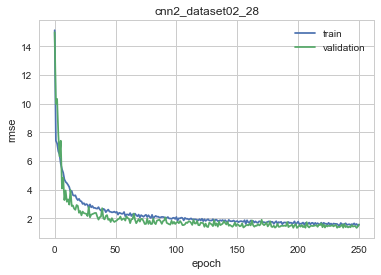

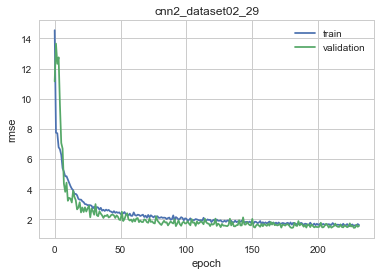

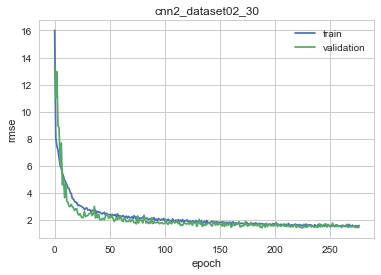

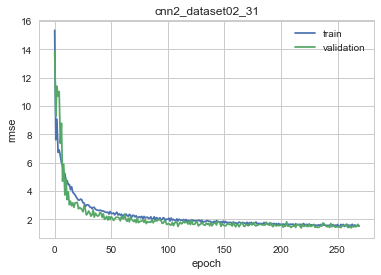

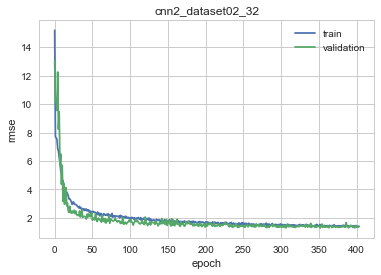

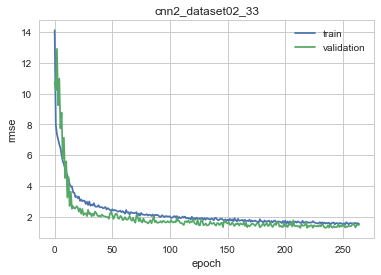

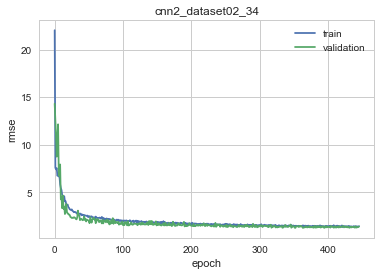

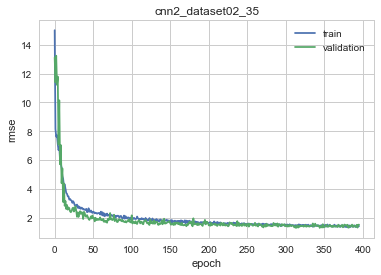

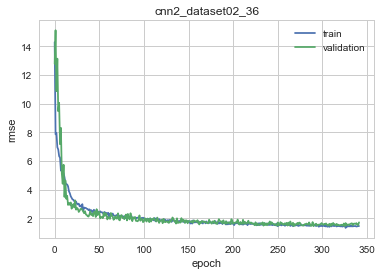

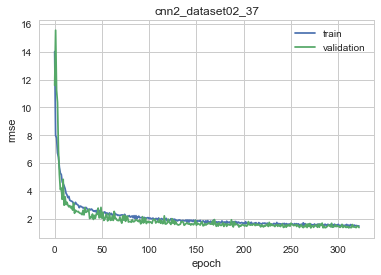

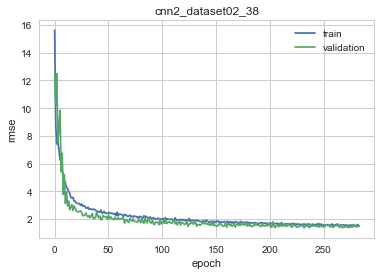

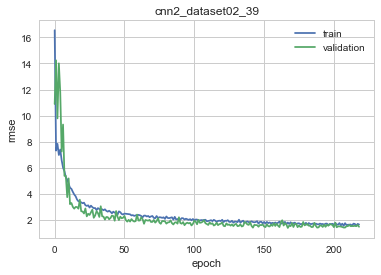

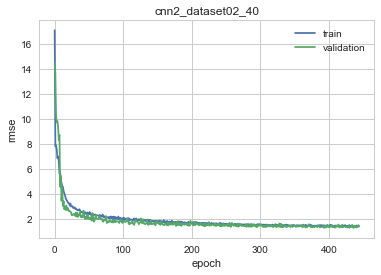

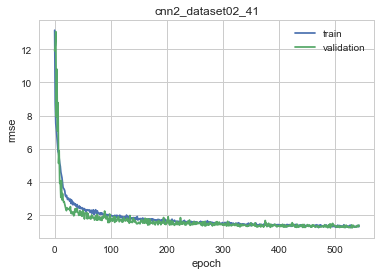

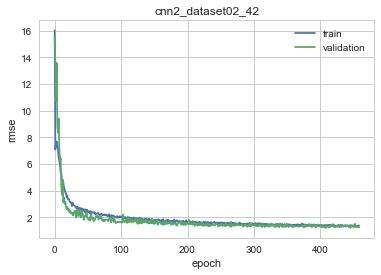

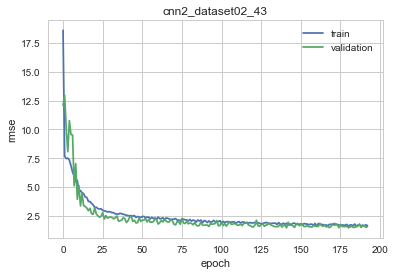

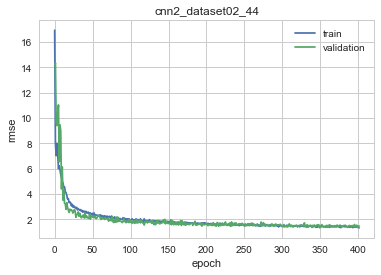

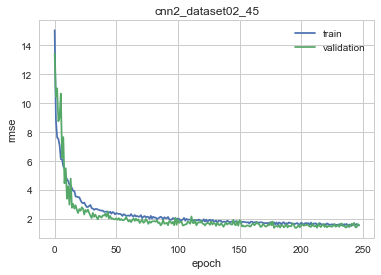

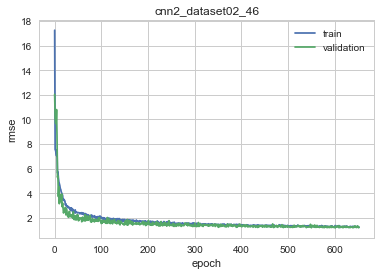

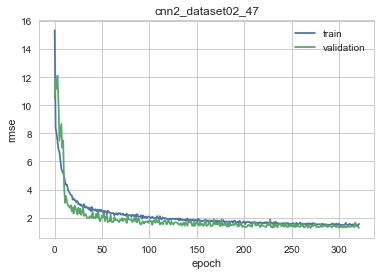

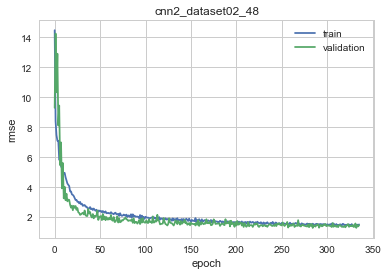

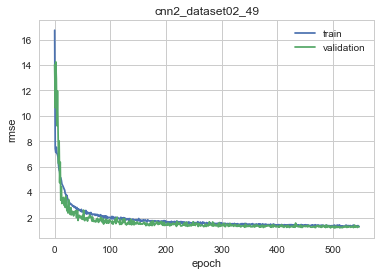

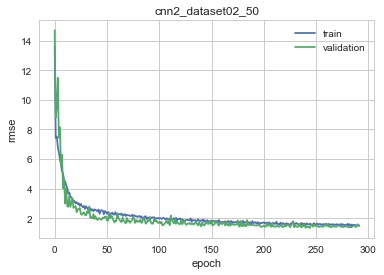

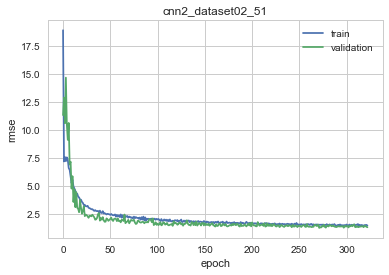

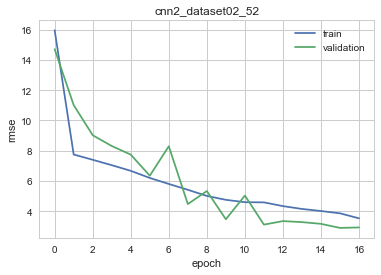

In [15]:
plot_loss_history(final_model_name, 'cnn2_dataset01', len(final_model[0]))
plot_loss_history(final_model_name, 'cnn2_dataset02', len(final_model[1]))

In [16]:
final_indexes08 = [7, 9, 15, 17, 22, 23, 27, 30, 40, 43, 55, 57] 
final_indexes22 = [0, 1, 2, 4, 8, 14, 17, 26, 27, 32, 34, 40, 41, 42, 46, 49]
final_selected_ensemble = pick_cnns(final_model, final_indexes08, final_indexes22)
_ = predict_and_make_submission_file(X_test, final_selected_ensemble)

submission_20171122_1255.csv created for submission.


# 6. Final Kaggle Submission
* score (RMSE): submission_20171122_0152.csv
  * public:  <strong>1.87261</strong>
  * private: <strong>1.64578</strong>
  
<img src="img/finalscore.png" />

### Private Leaderboard
<img src="img/private.png" />

### Public Leaderboard
<img src="img/public.png" />